# Paired integration (multiome)

In this notebook we showcase basic Multigrate functionality and integrate a multiome dataset (paired RNA-seq and ATAC-seq measurements) to obtain a joint gene expression and chromatin accesibility representation in a latent space. We use publically available dataset from NeurIPS 2021 workshop https://openproblems.bio/neurips_2021/. We use the preprocessed data (see preprocessing notebook).

In [1]:
import numpy as np
import scanpy as sc
import multigrate as mtg

Global seed set to 0


In [2]:
rna = sc.read('data/multiome/rna_multiome_hvg.h5ad')
rna

AnnData object with n_obs × n_vars = 69249 × 4000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'hvg', 'log1p', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [3]:
atac = sc.read('data/multiome/atac_hvf.h5ad')
atac

AnnData object with n_obs × n_vars = 69249 × 20000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'hvg', 'log1p', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts', 'log-norm', 'tf-idf'

## Prep the input AnnData object

First, we need to organize anndatas correspoding to different datasets and modalities into 1 anndata object. In this example we have 1 multiome dataset, hence we input 2 anndata objects: 1 for RNA modality and 1 for ATAC modality.

Notes:
- paired datasets have to have the same .obs_names, i.e. index
- each sublist in `adatas`, `layers` parameters corresponds to one modality. If you have multiple objects per modality, append them to the corresponding list;
- objects in each sublist *have* to have the same set of features: if you want to integrate multiple RNA objects, we recommend first concatenating full objects and then subsetting to 2000-4000 highly variable genes; additionally we subset ATAC objects to top ~20000 highly variable peaks.
- `layers` parameter specifies which layer the model should take the counts from. If `None`, then defaults to `.X`. The distribution of the input data should be the same within a modality, e.g. here we use raw counts for RNA-seq modality.

In [4]:
adata = mtg.data.organize_multiome_anndatas(
    adatas = [[rna], [atac]],           # a list of anndata objects per modality, RNA-seq always goes first
    layers = [['counts'], ['log-norm']],    # if need to use data from .layers, if None use .X
)
adata

AnnData object with n_obs × n_vars = 69249 × 24000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'group'
    var: 'modality'
    uns: 'modality_lengths'
    layers: 'counts'

From now on, we work with one concatenated anndata object ```adata```.

If using raw counts for scRNA-seq, we need to use NB loss (or ZINB), thus need to calculate `size_factors` first. If using normalized counts and MSE for gene expression, `rna_indices_end` does not need to be specified. Here we also want to correct for batch effects, so we specify  `batch` as a categorical covariate.

In [5]:
mtg.model.MultiVAE.setup_anndata(
    adata,
    rna_indices_end=4000, # how many features in the rna-seq modality
    categorical_covariate_keys=["batch"]
)

INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.X                                                                                   
INFO     Successfully registered anndata object containing 69249 cells, 24000 vars, 1 batches, 1 labels, and 0     
         proteins. Also registered 1 extra categorical covariates and 1 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                


## Initialize the model

Define the model here. If using raw counts for RNA-seq, use NB loss, if normalized counts, use MSE. For ATAC we use log-normalized counts and MSE loss.

In [6]:
model = mtg.model.MultiVAE(
    adata, 
    losses=['nb', 'mse'],
)

## Train the model

One can specify the number of epochs by setting `max_epochs` parameter, default is 256. The default batch size is set to `batch_size = 256`, adjust if needed.

In [7]:
model.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 83/200:  42%|████▏     | 83/200 [12:47<18:01,  9.24s/it, loss=1.88e+03, v_num=1]


Let's plot the losses.

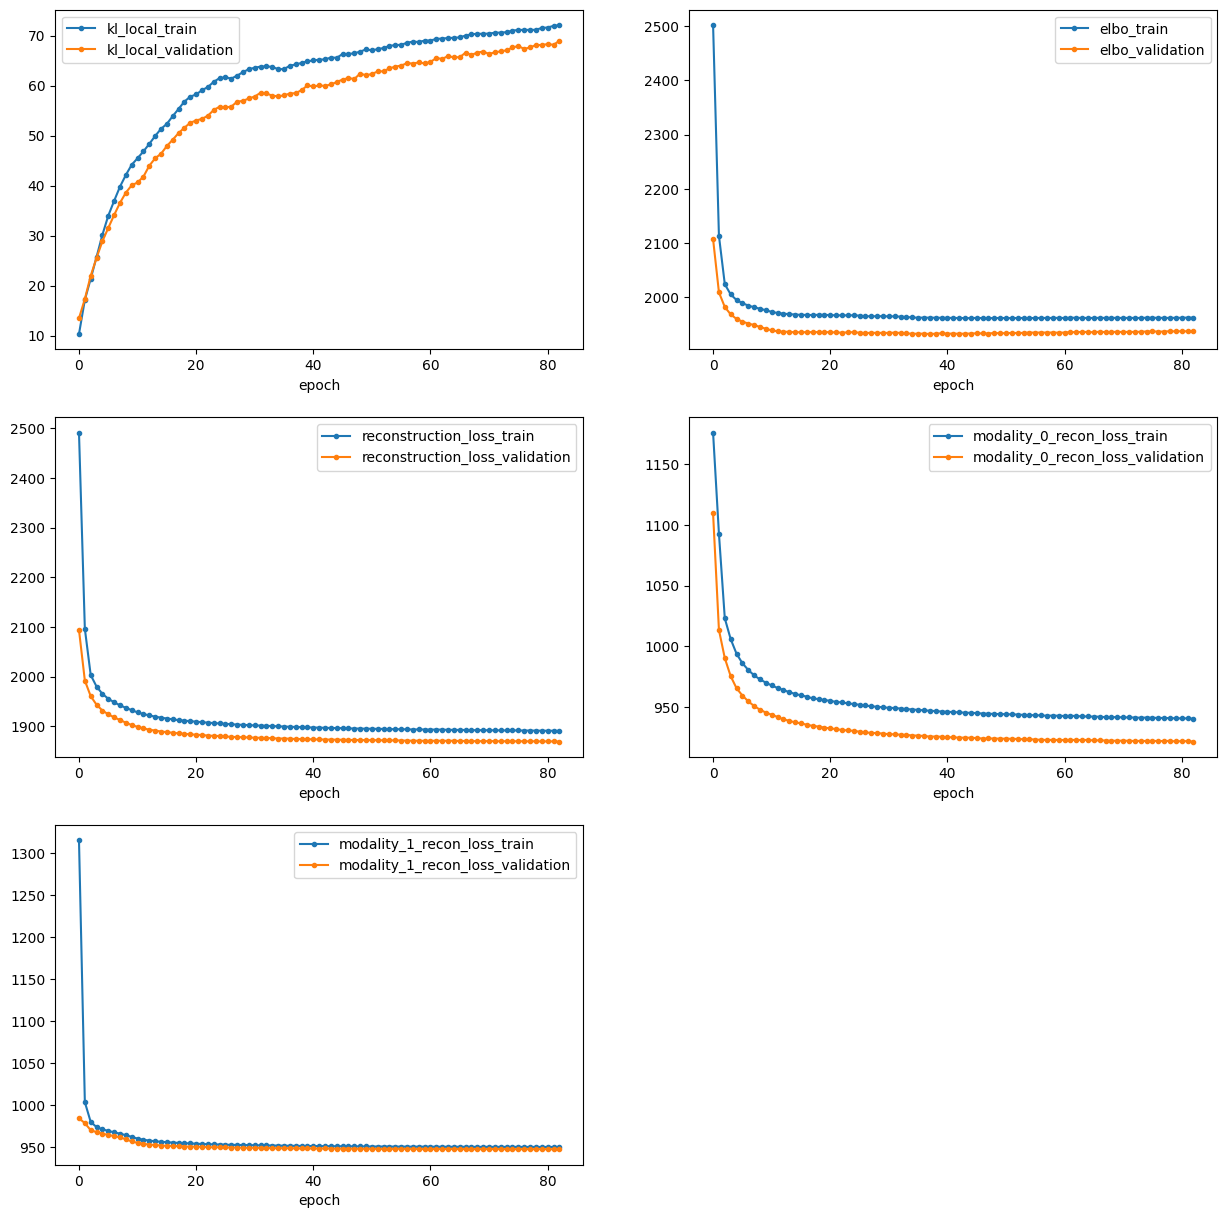

In [8]:
model.plot_losses()

## Inference

Get the latent representation.

In [9]:
model.get_latent_representation()
adata

AnnData object with n_obs × n_vars = 69249 × 24000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'group', 'size_factors', '_scvi_batch', '_scvi_labels'
    var: 'modality'
    uns: 'modality_lengths', '_scvi'
    obsm: '_scvi_extra_categoricals', '_scvi_extra_continuous', 'latent'
    layers: 'counts'

Visualize results.

In [10]:
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata)

/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate_test/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


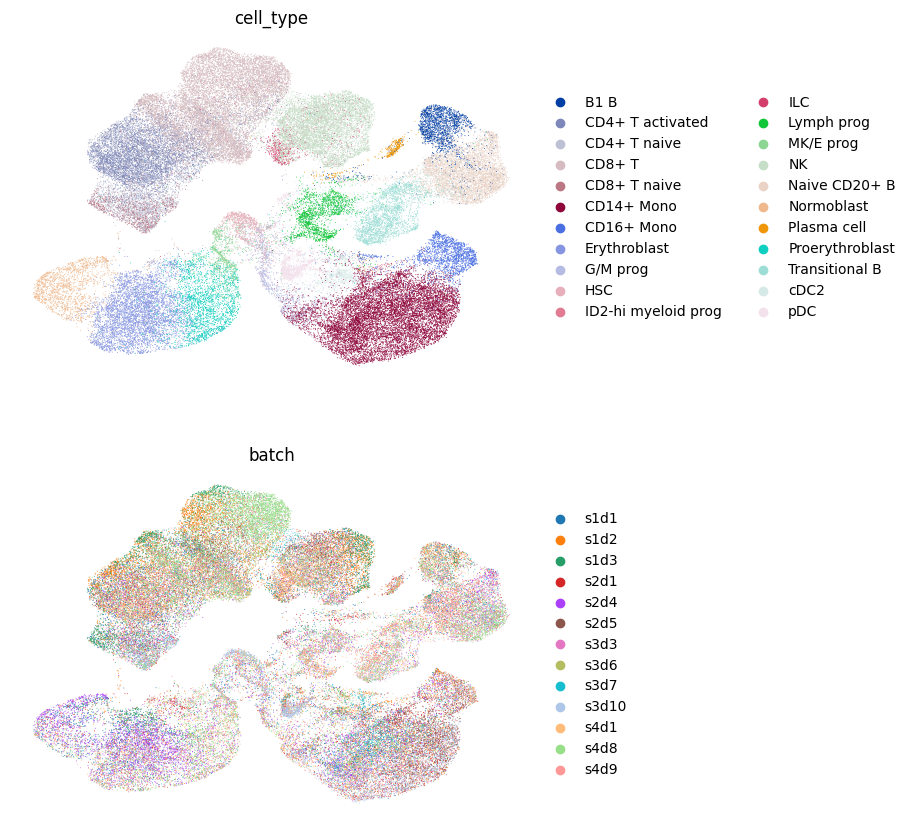

In [11]:
sc.pl.umap(adata, color=['cell_type', 'batch'], frameon=False, ncols=1)